# Detecção de fraude de cartão de crédito

#### Este notebook testará diferentes métodos em dados distorcidos. A ideia é comparar se as técnicas de pré-processamento funcionam melhor quando há uma classe majoritária esmagadora que pode atrapalhar a eficiência do nosso modelo preditivo.

#### Você também poderá ver como aplicar a validação cruzada para ajuste de hiperparâmetros em diferentes modelos de classificação. Minha intenção é criar modelos usando:
1. Regressão Logística
2. Redes neurais

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Carregando e explorando o dataset

Os dados foram obtidos no Kaggle e podem ser encontrados [aqui](https://www.kaggle.com/mlg-ulb/creditcardfraud).

In [2]:
data = pd.read_csv("./data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Verificando a frequência de cada classe

Number of transactions:  284807
Number of frauds:  492
Number of valid:  284315


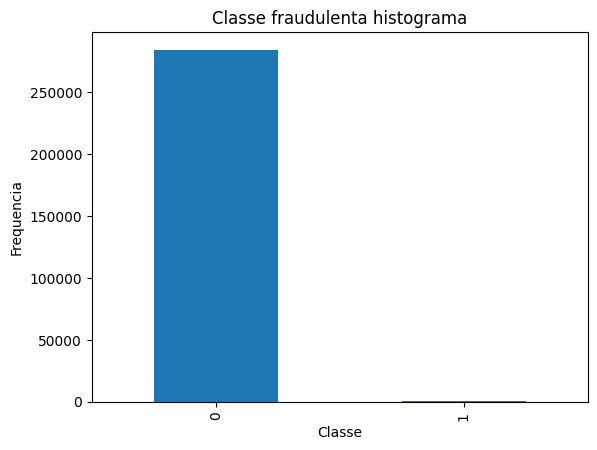

In [3]:
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Classe fraudulenta histograma")
plt.xlabel("Classe")
plt.ylabel("Frequencia")

print("Number of transactions: ", data.shape[0])
print("Number of frauds: ", data['Class'].value_counts()[1])
print("Number of valid: ", data['Class'].value_counts()[0])

#### Dados do dataset:
- numero de features: 30
- numero de amostras: 284.807
- numero de amostras da classe positiva: 492
- numero de amostras da classe negativa: 284.315
- proporção entre as classes: 0.172% (positivas), 99.828% (negativas)

#### Dados desbalanceados!

- Alteração da métrica de desempenho:
    - Use a matriz de confusão para calcular precisão, recuperação
    - F1score (média ponderada de recuperação de precisão)
    - Utilizar Kappa – que é uma precisão de classificação normalizada pelo desequilíbrio das classes nos dados
    - Curvas ROC - calcula a relação sensibilidade/especificidade.

- Reamostragem do conjunto de dados
    - Essencialmente, este é um método que processará os dados para ter uma proporção aproximada de 50-50.
    - Uma maneira de conseguir isso é por sobreamostragem, que consiste em adicionar cópias da classe sub-representada (melhor quando você tem poucos dados)
    - Outra é a subamostragem, que exclui instâncias da classe sobre-representada (melhor quando ele tem muitos dados)

### Abordagem

1. Não realizaremos engenharia de recursos em primeira instância. O conjunto de dados foi rebaixado para conter 30 features (28 anonimizados* + time + amount).
2. Em seguida, compararemos o que acontece quando usamos a resampling ou reamostragem e quando não a usamos. Testaremos essa abordagem usando um classificador de regressão logística simples.
3. Avaliaremos os modelos usando algumas das métricas de desempenho mencionadas acima.
4. Repetiremos o melhor método de reamostragem/não reamostragem, ajustando os parâmetros no classificador de regressão logística.
5. Finalmente realizaremos o modelo de classificações usando outros algoritmos de classificação.

# Configuração, normalização e reamostragem do dataset

#### 1. Normalizando a coluna "Amount", ela não está de acordo com os recursos anonimizados.

In [4]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


#### 2. Reamostragem.
![assets/resampling.png](assets/resampling.png)
- Usaremos a abordagem undersampling, isso sera feito selecionando aleatoriamente “N” quantidade de amostra da classe majoritária, sendo “N” é o número total de registros da classe minoritária.

- Porque dessa escolha?
    - A classe majoritátia é muito grande, no qual torna o treinamento muito lento além de ser composta por em sua grande maioria de dados que não são relevantes para o modelo. Possui muito ruído ou rendundântes.




In [5]:
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']


In [6]:
# Numero de pontos de dados na classe minoritaria

number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

# Selecionando os indices das classes normais
normal_indices = data[data.Class == 0].index

# Fora dos indices que escolhemos, selecione aleatoriamente "x" número (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace=False)
random_normal_indices = np.array(random_normal_indices)

# adicionando os dois indices
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

# Under sample dataset
under_sample_data = data.loc[under_sample_indices, :]

X_undersample = under_sample_data.loc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.loc[:, under_sample_data.columns == 'Class']

# Proporções dos dados
print("Porcentagem de transações não fraudulentas: ", len(under_sample_data[under_sample_data.Class == 0]) / len(under_sample_data))
print("Porcentagem de transações fraudulentas: ", len(under_sample_data[under_sample_data.Class == 1]) / len(under_sample_data))
print("Numero total de transações: ", len(under_sample_data))

Porcentagem de transações não fraudulentas:  0.5
Porcentagem de transações fraudulentas:  0.5
Numero total de transações:  984


# Divisão de dados em conjunto de treinamento e teste. 
A cross validation será usada ao calcular precisões.


In [7]:
from sklearn.model_selection import train_test_split

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Numero de transações do dataset de treino:: ", len(X_train))
print("Numero de transações do dataset de teste:: ", len(X_test))
print("Numero de total de transações: ", len(X_train)+len(X_test))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Numero de transações do dataset de treino: ", len(X_train_undersample))
print("Numero de transações do dataset de teste: ", len(X_test_undersample))
print("Numero de total de transações: ", len(X_train_undersample)+len(X_test_undersample))



Numero de transações do dataset de treino::  199364
Numero de transações do dataset de teste::  85443
Numero de total de transações:  284807

Numero de transações do dataset de treino:  688
Numero de transações do dataset de teste:  296
Numero de total de transações:  984


# Classificador de regressão logística - Dados subamostrados
Estamos muito interessados ​​na pontuação do recall, porque essa sera a métrica que nos ajudará a tentar capturar as transações mais fraudulentas. Se você pensar como Precisão, Acuracia e Recall funcionam para uma matriz de confusão, o recall seria o mais interessante:

![assets/indicators.ppm](assets/indicators.ppm)

Certamente! Vamos discutir os indicadores de precisão, acurácia e recall, seus significados e quando cada um é mais importante:

1. **Precisão (Precision):**
   - **Significado:** Precisão é a proporção de instâncias relevantes recuperadas pelo modelo em relação ao total de instâncias recuperadas.
   - **Fórmula:** Precisão = TP / (TP + FP), onde TP é o número de verdadeiros positivos e FP é o número de falsos positivos.
   - **Importância:** A precisão é crucial quando o custo de falsos positivos é alto. Por exemplo, em um sistema de detecção de spam de e-mails, é importante garantir que e-mails legítimos não sejam marcados como spam.

2. **Acurácia (Accuracy):**
   - **Significado:** Acurácia é a medida geral da corretude do modelo, representando a proporção de instâncias corretamente classificadas em relação ao total de instâncias.
   - **Fórmula:** Acurácia = (TP + TN) / (TP + TN + FP + FN), onde TN é o número de verdadeiros negativos e FN é o número de falsos negativos.
   - **Importância:** A acurácia é comumente usada quando as classes do conjunto de dados estão balanceadas. No entanto, pode ser enganadora em conjuntos de dados desbalanceados, onde uma classe é muito mais prevalente que a outra.

3. **Recall (Revocação ou Sensibilidade):**
   - **Significado:** Recall é a proporção de instâncias relevantes que foram corretamente recuperadas pelo modelo em relação ao total de instâncias relevantes.
   - **Fórmula:** Recall = TP / (TP + FN), onde TP é o número de verdadeiros positivos e FN é o número de falsos negativos.
   - **Importância:** Recall é vital quando a identificação correta dos positivos é crucial, mesmo que isso resulte em mais falsos positivos. Por exemplo, em um sistema de diagnóstico médico, é fundamental capturar todos os casos positivos, mesmo que alguns sejam falsos positivos.

**Quando cada um é mais importante:**
- **Precisão:** Importante quando o custo dos falsos positivos é alto, e queremos minimizar os casos em que uma instância negativa é incorretamente classificada como positiva.
  
- **Acurácia:** Adequada quando as classes estão balanceadas e o objetivo é avaliar a capacidade global do modelo em prever corretamente.

- **Recall:** Crítico quando a identificação correta dos positivos é fundamental, mesmo que isso resulte em alguns falsos positivos. Essencial em cenários onde perder um positivo (falso negativo) é mais custoso do que ter alguns falsos positivos.

Em resumo, a escolha entre precisão, acurácia e recall depende do contexto e das consequências práticas de erros específicos no seu problema de classificação.

#### Função p/ imprimir K_fold_scores
A validação cruzada com K dobras, ou "K-fold cross-validation" em inglês, é uma técnica comum em aprendizado de máquina para avaliar o desempenho de um modelo. Nesse método, o conjunto de dados é dividido em K subconjuntos (dobras), e o modelo é treinado K vezes, cada vez utilizando K-1 subconjuntos para treinamento e o subconjunto restante para validação. Isso é repetido K vezes, alternando qual subconjunto é usado para validação.

Ao final do processo, são obtidos K conjuntos de métricas de desempenho. A média dessas métricas fornece uma estimativa mais robusta do desempenho do modelo do que uma única divisão treino-teste. A validação cruzada é especialmente útil para evitar o overfitting, pois o modelo é testado em diferentes conjuntos de dados de validação durante o processo, garantindo uma avaliação mais abrangente do seu desempenho. O valor comum de K é 5 ou 10, mas pode variar dependendo do contexto e do tamanho do conjunto de dados.

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

lr = LogisticRegression(penalty='l1', solver='liblinear')

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_undersample, y_train_undersample.values.ravel())

print("Melhor valor de C:", grid_search.best_params_['C'])
best_C = grid_search.best_params_['C']

Melhor valor de C: 0.01


#### Função p/ renderizar a matriz de confusão
A matriz de confusão é uma tabela que descreve o desempenho de um modelo de classificação em termos de verdadeiros positivos (TP), falsos positivos (FP), verdadeiros negativos (TN) e falsos negativos (FN). Ela é usada para avaliar a precisão de um modelo em relação às classes previstas e reais.

In [9]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Previsões no conjunto de testes e plotagem da matriz de confusão

#### Temos falado sobre o uso da métrica de recall como indicador da eficácia do nosso modelo preditivo. Embora o recall ainda seja o recall que queremos calcular, lembre-se de que os dados subamostrados não apresentam assimetria em relação a uma determinada classe, o que não torna a métrica de recall tão crítica.

Recall obtained:  0.9387755102040817


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


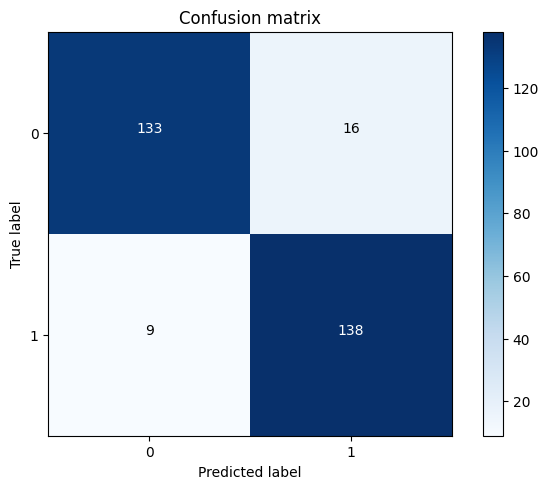

In [10]:

lr = LogisticRegression(C=best_C, penalty='l1', solver='liblinear')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

cnf_matrix = confusion_matrix(y_test_undersample, y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall obtained: ", recall_score(y_test_undersample, y_pred_undersample))

# Plot non-normalized confusion matrix
class_names = [0, 1]
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

Obtemos um recall de 93,2% nos dados de teste(undersample), agora vamos aplicar o modelo que ajustamos e testá-lo em todos os dados de teste.

C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Recall:  0.9183673469387755


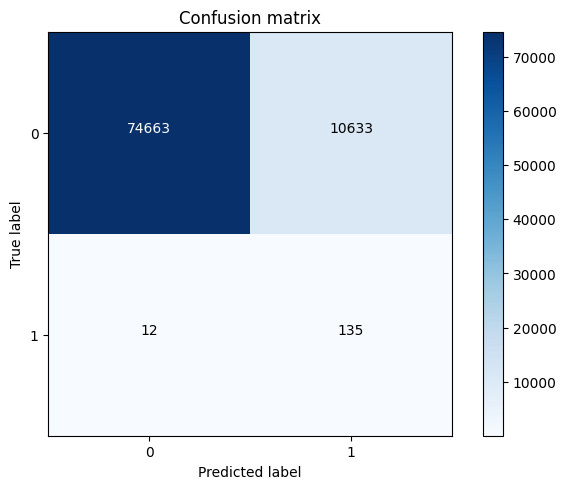

In [11]:
lr = LogisticRegression(C=best_C, penalty='l1', solver='liblinear')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)

# Computando a matriz de confusão
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

print("Recall: ", recall_score(y_test, y_pred))

# Plot da matriz de confusão não normalizada
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

### Ainda uma precisão de recall muito decente quando aplicada a um conjunto de dados muito maior e distorcido!

#### Podemos começar a ficar felizes com o funcionamento da abordagem inicial.

### Curva ROC 
A Curva ROC é uma ferramenta gráfica utilizada na avaliação de desempenho de modelos de classificação binária. Ela representa a taxa de verdadeiros positivos (sensibilidade) em função da taxa de falsos positivos (1 - especificidade) para diferentes valores de limiar de decisão do modelo.

Ao plotar essa curva, pode-se visualizar o equilíbrio entre a sensibilidade e a especificidade em diversos pontos de corte, permitindo a escolha do limiar que melhor atenda aos objetivos do problema. Uma curva ROC ideal se aproxima rapidamente do canto superior esquerdo do gráfico, indicando alta sensibilidade e baixa taxa de falsos positivos.

O AUC-ROC (Área Sob a Curva da Curva ROC) é uma métrica comum associada à Curva ROC. Quanto maior o AUC-ROC (variando de 0 a 1), melhor o desempenho do modelo. Um valor de 0,5 indica desempenho aleatório, enquanto 1 representa um desempenho perfeito.

C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


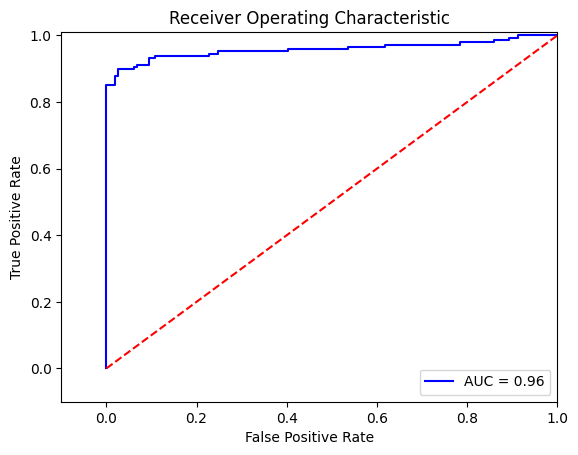

In [12]:
# ROC CURVE
lr = LogisticRegression(C=best_C, penalty='l1', solver='liblinear')
y_pred_undersample_score = lr.fit(X_train_undersample, y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(), y_pred_undersample_score)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Rede Neural

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping




Epoch 1/1000


22/22 [==============================] - 2s 19ms/step - loss: 0.6403 - accuracy: 0.6352 - val_loss: 0.5449 - val_accuracy: 0.7365
Epoch 2/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.4898 - accuracy: 0.8140 - val_loss: 0.4490 - val_accuracy: 0.8581
Epoch 3/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.4001 - accuracy: 0.8721 - val_loss: 0.3788 - val_accuracy: 0.8784
Epoch 4/1000
22/22 [==============================] - 0s 10ms/step - loss: 0.3327 - accuracy: 0.9041 - val_loss: 0.3270 - val_accuracy: 0.8919
Epoch 5/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.2840 - accuracy: 0.9157 - val_loss: 0.2844 - val_accuracy: 0.9054
Epoch 6/1000
22/22 [==============================] - 0s 7ms/step - loss: 0.2457 - accuracy: 0.9273 - val_loss: 0.2528 - val_accuracy: 0.9088
Epoch 7/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.2167 - accuracy: 0.9317 - val_loss: 0.2281 - val_accuracy: 0.9223


<Axes: >

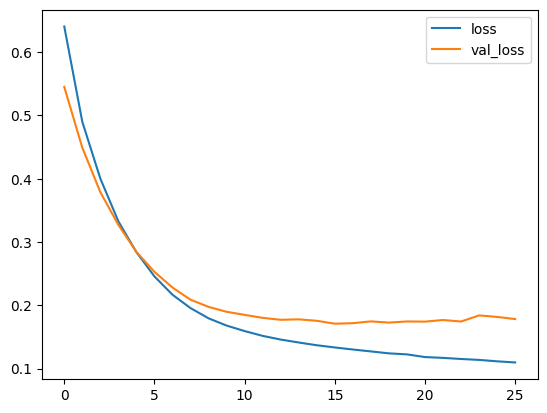

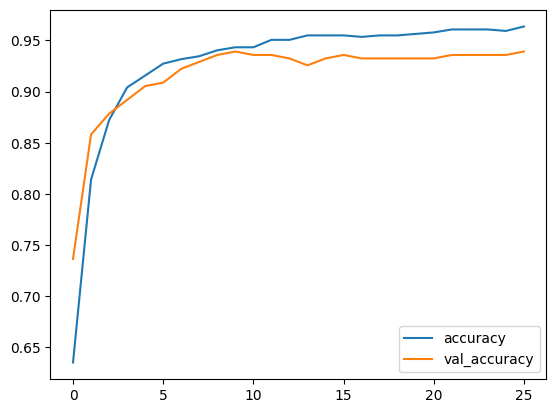

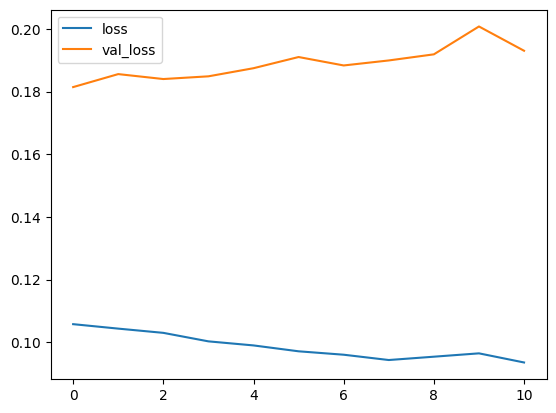

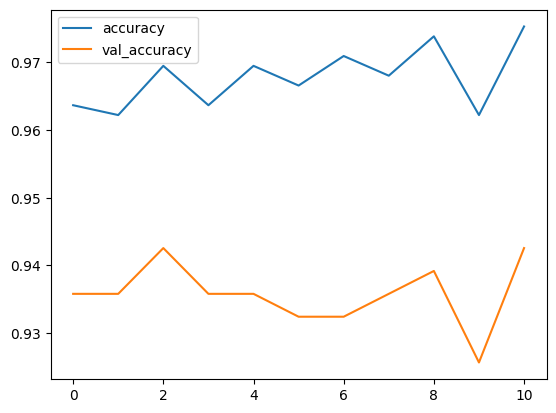

In [15]:
# Padronize os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_undersample)
X_test_scaled = scaler.transform(X_test_undersample)

# Construa o modelo da rede neural
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=29))  # Update input_dim to 29
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treine o modelo
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model.fit(x=X_train_scaled, y=y_train_undersample, epochs=1000, validation_data=(X_test_scaled, y_test_undersample),
          callbacks=[early_stop])

# Avalie o modelo
losses = pd.DataFrame(model.history.history)
losses[['loss', 'val_loss']].plot()
losses[['accuracy', 'val_accuracy']].plot()

# Predict classes
predictions = (model.predict(X_test_scaled) > 0.5).astype(int)
print(classification_report(y_test_undersample, predictions))
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model.fit(x=X_train_scaled, y=y_train_undersample, epochs=1000, validation_data=(X_test_scaled, y_test_undersample),
          callbacks=[early_stop])

# Avalie o modelo
losses = pd.DataFrame(model.history.history)
losses[['loss', 'val_loss']].plot()
losses[['accuracy', 'val_accuracy']].plot()



Topologia da rede neural:
- 30 entradas
- 2 camadas ocultas (32 neurônios a primeira e 16 a segunda)
- 1 saída

![assets/rede_neural_topology.png](assets/rede_neural_topology.png)


2671/2671 [==============================] - 4s 2ms/step
Matriz de Confusão:
 [[81585  3711]
 [    7   140]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     85296
           1       0.04      0.95      0.07       147

    accuracy                           0.96     85443
   macro avg       0.52      0.95      0.52     85443
weighted avg       1.00      0.96      0.98     85443

Recall:  0.9523809523809523
2671/2671 [==============================] - 4s 2ms/step


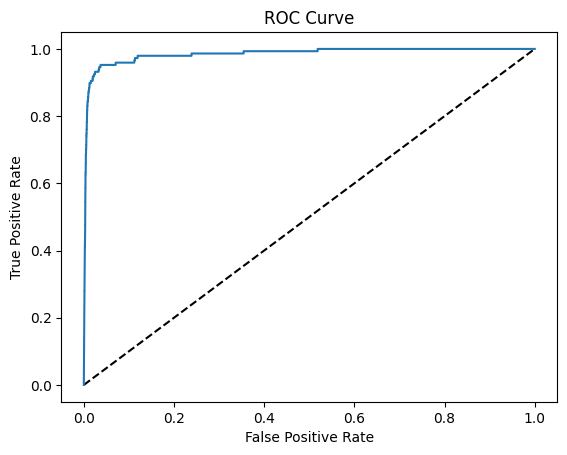

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, recall_score

# Avalie o modelo nos dados de teste
X_test_scaled = scaler.transform(X_test)
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# Gere a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:\n", conf_matrix)

# Imprima o relatório de classificação
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

# ROC CURVE
from sklearn.metrics import roc_curve, roc_auc_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict(X_test_scaled)

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
